# Spatial Regression

* [Data manipulation](#Data)
* [Non-spatial linear model](#Non-spatial-linear-model)
* [Spatial Durbin model](#Spatial-Durbin-model)
* [Spatial error model](#Spatial-error-model)
* [Spatial lag model](#Spatial-lag-model)
* [General nested model](#Spatial-nested-model)
* [A note on *other* understandings of space in regression contexts](#Spatial-autocorrelation-Vs-spatial-dependence)

In [1]:
%matplotlib inline
from IPython.display import HTML

import geopandas
import pandas
import numpy as np
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
from pysal.lib import weights
from pysal.model import spreg
from pysal.model.spvcm import api as spvcm

## Data

* Read data

In [2]:
landprice = geopandas.read_file("../data/landprice.gpkg")
landprice.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1117 entries, 0 to 1116
Data columns (total 21 columns):
obs              1117 non-null int64
district.id.x    1117 non-null float64
lnprice          1117 non-null float64
lnarea           1117 non-null float64
lndcbd           1117 non-null float64
dsubway          1117 non-null float64
dpark            1117 non-null float64
dele             1117 non-null float64
popden           1117 non-null float64
crimerate        1117 non-null float64
district.id.y    1117 non-null int64
year             1117 non-null int64
fyear            1117 non-null object
price            1117 non-null float64
area             1117 non-null float64
Dcbd_            1117 non-null float64
Dsubway_         1117 non-null float64
Dpark_           1117 non-null float64
Dele_            1117 non-null float64
f_district.id    1117 non-null object
geometry         1117 non-null object
dtypes: float64(15), int64(3), object(3)
memory usage: 183.4+ KB


In [3]:
bp = geopandas.read_file("../data/Beijingdistricts.gpkg")
bp.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 111 entries, 0 to 110
Data columns (total 4 columns):
id          111 non-null int64
id1         111 non-null float64
counts      111 non-null int64
geometry    111 non-null object
dtypes: float64(1), int64(2), object(1)
memory usage: 3.6+ KB


* Weights

In [4]:
dnb1_5 = weights\
         .DistanceBand\
         .from_dataframe(landprice.set_index("obs"), 
                         1500,
                         binary=False)
dnb1_5.transform = 'R'

('WARNING: ', 517, ' is an island (no neighbors)')
('WARNING: ', 53, ' is an island (no neighbors)')
('WARNING: ', 292, ' is an island (no neighbors)')
('WARNING: ', 1764, ' is an island (no neighbors)')
('WARNING: ', 33, ' is an island (no neighbors)')
('WARNING: ', 1785, ' is an island (no neighbors)')
('WARNING: ', 1126, ' is an island (no neighbors)')


/opt/conda/lib/python3.7/site-packages/pysal/lib/weights/weights.py:168: UserWarning: There are 7 disconnected observations 
  Island ids: 517, 53, 292, 1764, 33, 1785, 1126
  " Island ids: %s" % ', '.join(str(island) for island in self.islands))


## Non-spatial linear model

* *Really* non-spatial

In [5]:
f = ("np.log(price) ~ np.log(area) + np.log(Dcbd_) + "\
     "np.log(Dele_) + np.log(Dpark_) + np.log(Dsubway_) + "\
     "crimerate + popden + fyear")
sm_ols = sm.ols(f, landprice).fit()
sm_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(price)   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     46.17
Date:                Thu, 05 Sep 2019   Prob (F-statistic):           1.22e-94
Time:                        00:27:10   Log-Likelihood:                -1374.5
No. Observations:                1117   AIC:                             2777.
Df Residuals:                    1103   BIC:                             2847.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           14.1539      0.370     38.243      0.000      13.428      14.880
fyear[T.2004]       -0.1645      0.058     -2.818      0.005      -0.279      -0.050
fyear[T.2005]        0.0176      0.125      0.141      0.888      -0.228       0.263
fyear[T.2006]       -0.1203      0.107     -1.122      0.262      -0.331       0.090
fyear[T.2007]        0.5514      0.117      4.695      0.000       0.321       0.782
fyear[T.2008]        0.3962      0.130      3.058      0.002       0.142       0.650
fyear[T.2009]        2.1137      0.229      9.243      0.000       1.665       2.562
np.log(area)        -0.0083      0.019     -0.442      0.659      -0.045       0.028
np.log(Dcbd_)       -0.2506      0.048     -5.248      0.000      -0.344      -0.157
np.log(Dele_)       -0.0855      0.032     -2.647      0.008      -0.149      -0.022
np.log(Dpark_)      -0.2844      0.046     -6.176      0.000      -0.375      -0.194
np.log(Dsubway_)    -0.2457      0.035     -7.071      0.000      -0.314      -0.178
crimerate            0.0077      0.004      1.720      0.086      -0.001       0.016
popden               0.0328      0.010      3.186      0.001       0.013       0.053
==============================================================================
Omnibus:                       18.917   Durbin-Watson:                   1.586
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.847
Skew:                           0.290   Prob(JB):                     4.90e-05
Kurtosis:                       3.300   Cond. No.                         283.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* The `PySAL` way

In [6]:
fyear_dummies = pandas.get_dummies(landprice["fyear"])\
                      .drop("2003", axis=1)\
                      .rename(lambda col: f"fyear{col}",
                              axis=1)
fyear_dummies.head()

,fyear2004,fyear2005,fyear2006,fyear2007,fyear2008,fyear2009
0,1,0,0,0,0,0
1,1,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


In [7]:
name_y = ["lnprice"]
name_x = ["lnarea", "lndcbd", "dele",
          "dpark", "dsubway", "crimerate",
          "popden"] + \
          fyear_dummies.columns.tolist()
ps_ols = spreg.OLS(landprice[name_y].values,
                   landprice.join(fyear_dummies)\
                            [name_x]\
                            .values,
                   name_y=name_y,
                   name_x=name_x,
                   w=dnb1_5,
                   moran=True,
                   spat_diag=True)
print(ps_ols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  : ['lnprice']                Number of Observations:        1117
Mean dependent var  :      7.4144                Number of Variables   :          14
S.D. dependent var  :      1.0297                Degrees of Freedom    :        1103
R-squared           :      0.3524
Adjusted R-squared  :      0.3448
Sum squared residual:     766.248                F-statistic           :     46.1700
Sigma-square        :       0.695                Prob(F-statistic)     :   1.219e-94
S.E. of regression  :       0.833                Log likelihood        :   -1374.458
Sigma-square ML     :       0.686                Akaike info criterion :    2776.916
S.E of regression ML:      0.8282                Schwarz criterion     :    2847.174

-----------------------------------------------------------------------------

## Spatial Durbin model

* Linear model with selected spatially lagged covariates

In [8]:
to_splag = ["lnarea", "lndcbd", "dele",
            "dpark", "dsubway", "crimerate",
            "popden"]
wx = weights.lag_spatial(dnb1_5,
                         landprice[to_splag])
wx = pandas.DataFrame(wx, 
                      index=landprice.index,
                      columns=[f"w_{i}" for i in to_splag])

In [9]:
name_y = ["lnprice"]
name_x = ["lnarea", "lndcbd", "dele",
          "dpark", "dsubway", "crimerate",
          "popden"] + \
          fyear_dummies.columns.tolist() + \
          wx.columns.tolist()
slx = spreg.OLS(landprice[name_y].values,
                landprice.join(fyear_dummies)\
                         .join(wx)\
                         [name_x]\
                         .values,
                name_y=name_y,
                name_x=name_x,
                w=dnb1_5,
                moran=True,
                spat_diag=True)
print(slx.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  : ['lnprice']                Number of Observations:        1117
Mean dependent var  :      7.4144                Number of Variables   :          21
S.D. dependent var  :      1.0297                Degrees of Freedom    :        1096
R-squared           :      0.3672
Adjusted R-squared  :      0.3557
Sum squared residual:     748.698                F-statistic           :     31.8036
Sigma-square        :       0.683                Prob(F-statistic)     :   2.012e-94
S.E. of regression  :       0.827                Log likelihood        :   -1361.518
Sigma-square ML     :       0.670                Akaike info criterion :    2765.035
S.E of regression ML:      0.8187                Schwarz criterion     :    2870.422

-----------------------------------------------------------------------------

## Spatial error model

In [10]:
name_y = ["lnprice"]
name_x = ["lnarea", "lndcbd", "dele",
          "dpark", "dsubway", "crimerate",
          "popden"] + \
          fyear_dummies.columns.tolist()
sdem = spreg.GM_Error_Het(landprice[name_y].values,
                            landprice.join(fyear_dummies)\
                                     [name_x]\
                                     .values,
                            name_y=name_y,
                            name_x=name_x,
                            w=dnb1_5)
print(sdem.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED LEAST SQUARES (HET)
---------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  : ['lnprice']                Number of Observations:        1117
Mean dependent var  :      7.4144                Number of Variables   :          14
S.D. dependent var  :      1.0297                Degrees of Freedom    :        1103
Pseudo R-squared    :      0.3452
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      14.4720357       0.7376587      19.6188766       0.0000000
              lnarea      -0.0299784       0.0197612      -1.5170315       0.12

But... the end of the story? No!

* Multi-level, non-spatial model

In [11]:
mlm_1 = sm.mixedlm(f, 
                   landprice, 
                   groups=landprice["f_district.id"])\
          .fit()

* Multi-level, spatial (Bayesian) model

In [12]:
w_districts = weights.Queen.from_dataframe(bp)
membership = landprice["f_district.id"].values

In [13]:
name_y = ["lnprice"]
name_x = ["lnarea", "lndcbd", "dele",
          "dpark", "dsubway", "crimerate",
          "popden"] + \
          fyear_dummies.columns.tolist()
vcsem = spvcm.upper.Upper_SE(landprice[name_y].values,
                             landprice.join(fyear_dummies)\
                                      [name_x]\
                                      .values, 
                             M=w_districts, 
                             membership=membership, 
                             n_samples=5000,
                             configs=dict(tuning=1000, 
                                          adapt_step=1.01)
                            )

100%|██████████| 5000/5000 [01:13<00:00, 68.28it/s]


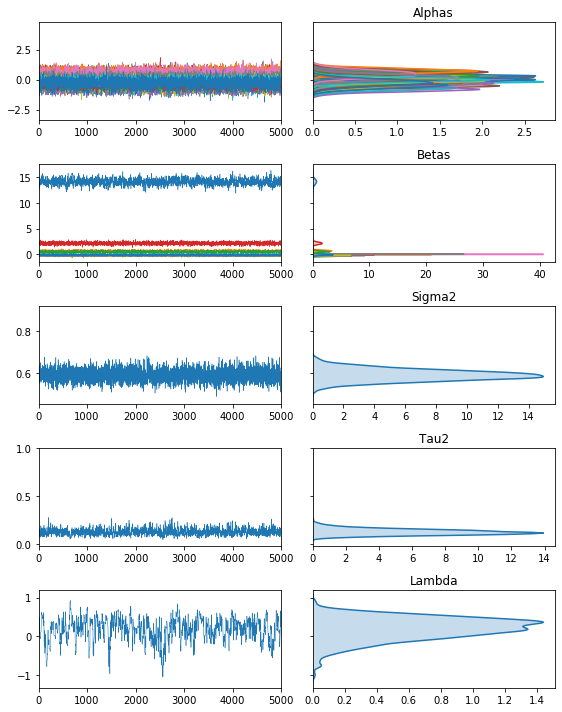

In [14]:
vcsem.trace.plot();

## Spatial lag model

In [15]:
name_y = ["lnprice"]
name_x = ["lnarea", "lndcbd", "dele",
          "dpark", "dsubway", "crimerate",
          "popden"] + \
          fyear_dummies.columns.tolist()
sp_lag_2sls = spreg.GM_Lag(landprice[name_y].values,
                           landprice.join(fyear_dummies)\
                                    [name_x]\
                                    .values,
                           w=dnb1_5,
                           name_y=name_y[0],
                           name_x=name_x
                          )
print(sp_lag_2sls.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     lnprice                Number of Observations:        1117
Mean dependent var  :      7.4144                Number of Variables   :          15
S.D. dependent var  :      1.0297                Degrees of Freedom    :        1102
Pseudo R-squared    :      0.3920
Spatial Pseudo R-squared:  0.3535

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      12.3146179       0.7275459      16.9262408       0.0000000
              lnarea      -0.0075381       0.0179937      -0.4189315       0.6752662
              lndcbd      -0.2152017       0.0475963      -

## General nested model

In [16]:
name_y = ["lnprice"]
name_x = ["lnarea", "lndcbd", "dele",
          "dpark", "dsubway", "crimerate",
          "popden"] + \
          fyear_dummies.columns.tolist()
sp_combo = spreg.GM_Combo_Het(
                           landprice[name_y].values,
                           landprice.join(fyear_dummies)\
                                    [name_x]\
                                    .values,
                           w=dnb1_5,
                           name_y=name_y[0],
                           name_x=name_x
                          )
print(sp_combo.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED TWO STAGE LEAST SQUARES (HET)
-------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     lnprice                Number of Observations:        1117
Mean dependent var  :      7.4144                Number of Variables   :          15
S.D. dependent var  :      1.0297                Degrees of Freedom    :        1102
Pseudo R-squared    :      0.3846
Spatial Pseudo R-squared:  0.3466
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      12.5522772       0.8800109      14.2637740       0.0000000
              lnarea     

## Comparison

In [17]:
resify = lambda m, plus: pandas.Series(m.betas.flatten(), 
                                       m.name_x+plus)

res = pandas.DataFrame({"OLS": resify(ps_ols, []),
                        "Spatial Durbin": resify(slx, []),
                        "Spatial Err.": resify(sdem, []),
                        "Spatial Lag": resify(sp_lag_2sls,
                                              ["Rho"]),
                        "Spatial Combo": resify(sp_combo,
                                                ["Rho",
                                                "lambda"]),
                       })
res.fillna('')

,OLS,Spatial Durbin,Spatial Err.,Spatial Lag,Spatial Combo
CONSTANT,14.1539,13.972,14.472,12.3146,12.5523
Rho,,,,0.12822,0.118402
crimerate,0.00766756,-5.39934e-05,0.00637062,0.00645767,0.00510758
dele,-0.0855275,0.00848508,-0.0454253,-0.0693675,-0.0373833
dpark,-0.284372,-0.0864308,-0.251466,-0.252253,-0.232501
dsubway,-0.245748,-0.169635,-0.21865,-0.213241,-0.198374
fyear2004,-0.164503,-0.164952,-0.212295,-0.171849,-0.211773
fyear2005,0.0176347,0.00757184,-0.112753,-0.0041415,-0.106601
fyear2006,-0.120314,-0.125488,-0.136452,-0.103246,-0.115546
fyear2007,0.551384,0.601048,0.718934,0.542693,0.691559


## Spatial autocorrelation Vs spatial dependence

In [18]:
embed = ('<div class="tenor-gif-embed" '\
         'data-postid="14625492" '\
         'data-share-method="host" '\
         'data-width="100%" '\
         'data-aspect-ratio="1.3423180592991915">'\
         '<a href="https://tenor.com/view/nhc12a3-'\
         'umbrella-violet-gif-14625492">Nhc12a3 '\
         'Umbrella GIF</a> from <a href='\
         '"https://tenor.com/search/nhc12a3-gifs">'\
         'Nhc12a3 GIFs</a></div><script '\
         'type="text/javascript" async '\
         'src="https://tenor.com/embed.js"></script>')
HTML(embed)